In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [3]:
%%writefile data/sq.py
"""3D flow around obstacle in a channel.
"""

import numpy as np
from sailfish.subdomain import Subdomain3D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

Lz = 256
H = 2*180
L = int(6.25/4 * H)
D = int(0.05 * L)



class BoxSubdomain(Subdomain3D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy, hz):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0, 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy, hz):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0
        sim.vz[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)
        sim.vz[12,153:211,1:44] = 0.1

class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'lat_nz': Lz,
            'precision': 'single',
            'max_iters': 10000,
            'model':'mrt',
            'grid':'D3Q19',
            'periodic_z':True,
            'gpus':[1],
            'visc': 0.001})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin,0),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin,64)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)

    def record_value(self, iteration, force, C_D, C_L):
        print iteration, force[0], force[1], force[2], C_D, C_L

    prev_f = None
    every = 500
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f



ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


Writing data/sq.py


In [4]:
!nvidia-smi

Wed Jun 22 15:30:41 2016       
+------------------------------------------------------+                       
| NVIDIA-SMI 352.79     Driver Version: 352.79         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40m          Off  | 0000:04:00.0     Off |                    0 |
| N/A   26C    P0    63W / 235W |     55MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40m          Off  | 0000:82:00.0     Off |                    0 |
| N/A   26C    P0    66W / 235W |     55MiB / 11519MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python data/sq.py --max_iters=1000000 --every=10000 --from=0000  --output=data/sq --output_format=npy  --subgrid='les-smagorinsky'

In [ ]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/sq.py --max_iters=100000 --every=1000 --from=80000 --output=data/sq --output_format=vtk 

In [48]:
import glob 
sorted(glob.glob("data/sq_smag0.2*.*"))

['data/sq_smag0.2.0.0000000.npz',
 'data/sq_smag0.2.0.0010000.npz',
 'data/sq_smag0.2.0.0020000.npz',
 'data/sq_smag0.2.0.0030000.npz',
 'data/sq_smag0.2.0.0040000.npz',
 'data/sq_smag0.2.0.0050000.npz',
 'data/sq_smag0.2.subdomains']

In [49]:
%%time 
from sailfish.util import vorticity
import glob
frames = []

for fn in sorted(glob.glob("data/sq.*.npz")):
    %time data = np.load(fn)
    vx,vy,vz  = data['v']
    rho = data['rho'] 
    %time w = vorticity([vx, vy,vz])
    frames.append([vx, vy,vz,np.sum(w**2,axis=0),rho])
print len(frames)
print frames[0][0].nbytes/1024**2

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 365 µs
CPU times: user 1.33 s, sys: 1.18 s, total: 2.5 s
Wall time: 2.5 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 172 µs
CPU times: user 1.32 s, sys: 1.18 s, total: 2.5 s
Wall time: 2.5 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 168 µs
CPU times: user 1.27 s, sys: 1.23 s, total: 2.5 s
Wall time: 2.5 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 198 µs
CPU times: user 1.31 s, sys: 1.18 s, total: 2.5 s
Wall time: 2.49 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 167 µs
CPU times: user 1.31 s, sys: 1.18 s, total: 2.49 s
Wall time: 2.49 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 611 µs
CPU times: user 1.42 s, sys: 1.08 s, total: 2.5 s
Wall time: 2.49 s
6
197
CPU times: user 34.3 s, sys: 9.2 s, total: 43.5 s
Wall time: 43.4 s


In [52]:
frames[0][0].shape

(256, 360, 562)

In [53]:
print frames[0][0].nbytes/1024**2,"MB"

197 MB


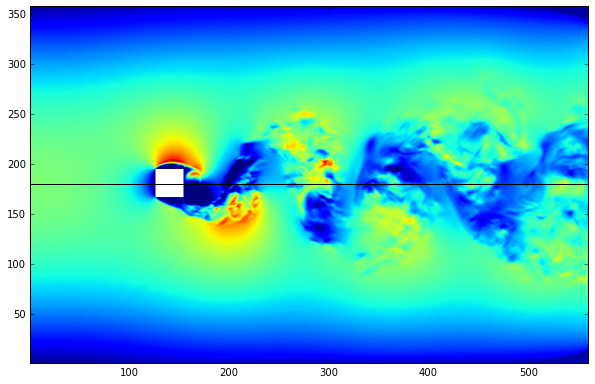

0.131005


In [57]:
from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
nz,ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          zi=widgets.IntSlider(min=0,max=(nz-1)),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'vz': 2,'rho':4,'vorticity':3},value=0)
         )
def g(ith,zi,figsize,sel):    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy,vz = frames[ith][:3]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel][zi,:,:],origin='top',vmin=-0.001,vmax=0.1)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show() 
    print np.nanmax(vx)

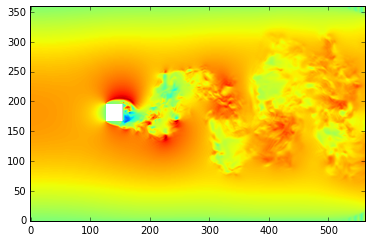

In [8]:
plt.imshow(frames[5][0][112,:,:],origin='top',vmin=-0.1,vmax=0.1)

In [15]:
np.nanmax( frames[5][0][112,:,:] ) 

0.090904586

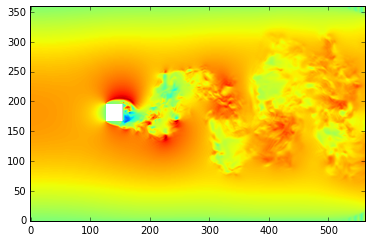

In [16]:
plt.imshow(frames[5][0][112,:,:],origin='top',vmin=-0.1,vmax=0.1)

In [ ]:
vx_smagframes[5][0][112,:,:]

In [19]:
from sailfish.util import vorticity

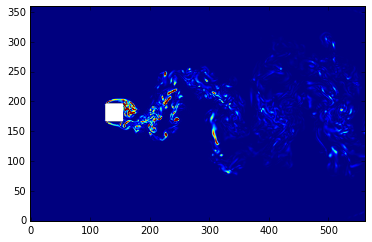

In [33]:
plt.imshow(frames[5][3][112,:,:],origin='top',vmin=0,vmax=0.001)

In [46]:
np.savez("data/vort",w=frames[5][3],v=data['v'])

In [42]:
src_data = np.load('data/vort.npz')
src_data.files
max(len(src_data[src_data.files[0]].shape), 0)


3

In [45]:
data['v'].shape

(3, 256, 360, 562)